**Problem:** Given data about mortality in Kenya. 

**Return:** Predict deaths that are likely to need fundraising. Use algorithm of your own choice. 
Include the confusion matrix, F1 score, sensitivity, and specificity.

In [1]:
# What folders are available
!ls

Data.csv                     df_clean_stage1
Keras.ipynb                  fixed_Obituaries_Dataset.csv
Obituaries_Dataset.csv       keras-one-cycle
Untitled.ipynb               plot_clr.py
__pycache__                  preliminary-work.ipynb
clr.py                       variables_explanied.txt


In [2]:
!pip install fastai==0.7.0

Okay, Let's look at the data and the codebook. NB This is a poorly formatted codebook no worries lets get to work

In [48]:
# Importing modules and packages
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Activation, Input 
from keras.utils import to_categorical 
from keras.layers import Flatten 
from keras.models import Model 
from keras import models 
from keras import layers
from sklearn.feature_extraction import DictVectorizer
from clr import LRFinder
from clr import OneCycleLR
from fastai.imports import *
from fastai.structured import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [49]:
# Let's see the data
df = pd.read_csv("fixed_Obituaries_Dataset.csv")

In [50]:
# first couple of rows and last rows
print("First 5 columns")
print(df.head().transpose())

print ("=" * 100)
print("")
print("Last 5 columns")
print(df.tail().transpose())

First 5 columns
                                               0                           1  \
Name                          Eng. Paul Chemweno        Edith Kiende Kiogora   
Announcement                          08/11/2017                  08/11/2017   
Death                                 02/11/2017                  27/10/2017   
Burial                                17/11/2017                  11/11/2017   
Burial_Day                                Friday                    Saturday   
Burial_Week                              Weekday                     Weekend   
Gender                                      Male                      Female   
Age                                           66                          43   
Color                                        Yes                         Yes   
Size                                       55.18                        83.6   
Word_Count                                   179                         293   
No_of_Children          

In [51]:
# convert the date columns into datetime
df["Burial"] = pd.to_datetime(df.Burial)
df["Announcement"] = pd.to_datetime(df.Announcement)
df["Death"] = pd.to_datetime(df['Death'])
#df2['Death_to_Burial'] = df2.Death_to_Burial.astype("float64")
#df2['Announce_to_Burial'] = df2.Announce_to_Burial.astype("float64") column dropped too many missing values
df['No_of_Relatives'] = df.No_of_Relatives.astype("float64")
df['Distance_Morgue'] = df.Distance_Morgue.astype("float64")

# got several errors in parsing therefore I manually changed the dataset i changed 20117 in entry 
# Caroline Nakhumicha Muyumbu on the announcement column
# Simon Muchiri Ngigii Mbaria had this symbol in the observation of announcement ` I removed it since pandas was
# throwing an error plus it doesn't make sense since it was not annotated in the codebook
# Uasin Gishu is also misspelled
# Mzee Harrison Onyango Ongong'a had a wrong entry on death i changed it 
# Mzee Wanderi Mugo also had a wrong entry that i fixed
# Alfred Dennis had weird entry too in death I fixed it too
# use grep --color "217" Obituaries_Dataset.csv
# for other patterns use grep --color pattern name of file

In [52]:
# look at concise summary of the dataset
df.info()

# 1291 rows and 39 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1264 non-null datetime64[ns]
Death                    892 non-null datetime64[ns]
Burial                   1164 non-null datetime64[ns]
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null float64
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        724 non-null object
Death_to_Burial          1237 non-null object
Announce_to_Burial       1273 non-null object
No_of_Relatives          1047 non-null

In [53]:
df.describe()

# 5 columns that are numerical and different thus we'll need to standardize the columns mean=1 and standard deviation=1

,Age,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,No_of_Relatives,Distance_Death,Distance_Morgue
count,507.000000,1237.000000,1237.000000,1093.000000,1092.000000,1083.000000,1047.000000,486.000000,871.000000
mean,65.422091,88.341496,212.953112,5.484904,1.011905,7.337950,18.415473,271.370370,95.783008
std,20.492632,55.520239,89.660233,4.319116,1.848240,12.351233,17.907033,1338.659678,147.232438
min,1.000000,53.430000,23.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000
25%,51.000000,56.070000,159.000000,3.000000,0.000000,0.000000,5.000000,0.000000,0.000000
50%,68.000000,68.640000,201.000000,4.000000,0.000000,2.000000,15.000000,0.000000,0.000000
75%,81.500000,104.680000,250.000000,8.000000,2.000000,8.000000,26.000000,151.000000,147.000000
max,117.000000,880.000000,2014.000000,30.000000,12.000000,79.000000,147.000000,13713.000000,789.000000


We have to process the data before continuing the analysis. The missing columns need to be dealt with or imputed or removed entirely also we have columns with very few observations. We are predicting on the column fundrraising. 

In [10]:
# checking the first observations
df.head().transpose()

,0,1,2,3,4
Name,Eng. Paul Chemweno,Edith Kiende Kiogora,Simon Muchiri Ngigii Mbaria,Mwalimu Erick Namusasi Werunga,Catherine Mueni Sina
Announcement,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00
Death,2017-02-11 00:00:00,2017-10-27 00:00:00,2017-01-11 00:00:00,2017-10-24 00:00:00,2017-02-11 00:00:00
Burial,2017-11-17 00:00:00,2017-11-11 00:00:00,2017-08-11 00:00:00,2017-09-11 00:00:00,2017-11-11 00:00:00
Burial_Day,Friday,Saturday,Wednesday,Thursday,Saturday
Burial_Week,Weekday,Weekend,Weekday,Weekday,Weekend
Gender,Male,Female,Male,Male,Female
Age,66,43,35,54,41
Color,Yes,Yes,Yes,Yes,No
Size,55.18,83.6,109.12,83.6,55.18


In [11]:
#checking the data types for each column
df.dtypes


Name                             object
Announcement             datetime64[ns]
Death                    datetime64[ns]
Burial                   datetime64[ns]
Burial_Day                       object
Burial_Week                      object
Gender                           object
Age                             float64
Color                            object
Size                            float64
Word_Count                      float64
No_of_Children                  float64
Significant_Children            float64
Significant_Relatives           float64
Fundraising                      object
Death_to_Announce                object
Death_to_Burial                  object
Announce_to_Burial               object
No_of_Relatives                 float64
County_Burial                    object
County_Death                     object
County_Morgue                    object
Distance_Death                  float64
Distance_Morgue                 float64
Cause_of_Death                   object


In [54]:
# Calculating the percentage of missing values 

# How many rows have observations that are null(NaN)
missing_values = df.isnull().sum()

# Percentage of missing values the dataset
# df.index.size finds the number of observations in the datase, you do df.shape[0] too!
percent_missing = ((missing_values / df.index.size) * 100)

# See the result
print(percent_missing)

Name                      0.000000
Announcement              2.091402
Death                    30.906274
Burial                    9.837335
Burial_Day                9.914795
Burial_Week               9.914795
Gender                    0.000000
Age                      60.728118
Color                     0.154919
Size                      4.182804
Word_Count                4.182804
No_of_Children           15.336948
Significant_Children     15.414407
Significant_Relatives    16.111541
Fundraising              11.541441
Death_to_Announce        43.919442
Death_to_Burial           4.182804
Announce_to_Burial        1.394268
No_of_Relatives          18.900077
County_Burial            19.132455
County_Death             59.333850
County_Morgue            31.835786
Distance_Death           62.354764
Distance_Morgue          32.532920
Cause_of_Death           38.187452
Married                  18.822618
Spouse_Alive             26.955848
Spouse_gender            27.575523
Hospital            

In [55]:
"Median percentage of missing values " + str(np.median(percent_missing))

'Median percentage of missing values 27.575522850503486'

Jeez! They are columns that are have almost nothing let's remove columns with greater than 80 percent missing values. Let's drop those columns and proceed to the next step.

In [56]:
# Make a list of observations whose columns have greater than or equal to observations that are missing
# This will prevent the model from learning since the matrices are empty
columns_to_drop = list(percent_missing[percent_missing >= 80].index)

print(columns_to_drop)

['Same_Morgue', 'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate', 'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category']


In [57]:
# columns are dropped
df_clean_stage1 = df.drop(columns_to_drop, axis=1)

print(df_clean_stage1)

                                        Name Announcement      Death  \
0                         Eng. Paul Chemweno   2017-08-11 2017-02-11   
1                       Edith Kiende Kiogora   2017-08-11 2017-10-27   
2                Simon Muchiri Ngigii Mbaria   2017-08-11 2017-01-11   
3             Mwalimu Erick Namusasi Werunga   2017-08-11 2017-10-24   
4                       Catherine Mueni Sina   2017-08-11 2017-02-11   
5                Maritha Mwendwa Mbui (Kaka)   2017-08-11 2017-02-11   
6               Mama Fransisca Nyarinda Mose   2017-07-11 2017-10-18   
7                     Onesmus Mwangi Gachahi   2017-07-11 2017-02-11   
8        WO1 (RTD) Jackson Gitonga Kirimania   2017-07-11 2017-03-11   
9                   Mama Lenah Nekesa Mamati   2017-07-11 2017-02-11   
10      Senior Chief Julius Cheruiyot Ng'eno   2017-07-11 2017-10-30   
11                       Lucy Gathoni Njunia   2017-08-11        NaT   
12                 Andrew Omolo Okal Stephen   2017-08-11 2017-1

In [58]:
# how much was lost
"We've lost " + str(df.shape[1] - df_clean_stage1.shape[1]) + " among the 39 columns -- 30 columns remain."

"We've lost 9 among the 39 columns -- 30 columns remain."

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1264 non-null datetime64[ns]
Death                    892 non-null datetime64[ns]
Burial                   1164 non-null datetime64[ns]
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null float64
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        724 non-null object
Death_to_Burial          1237 non-null object
Announce_to_Burial       1273 non-null object
No_of_Relatives          1047 non-null

In [59]:
# remove columns with too many missing values and would prevent the model from learning anything
df_clean_stage1 = df.drop(['Death_to_Announce','Death_to_Burial','Announce_to_Burial'], axis = 1)

In [60]:
# changing orientation of the dataframs
df_clean_stage1.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290
Name,Eng. Paul Chemweno,Edith Kiende Kiogora,Simon Muchiri Ngigii Mbaria,Mwalimu Erick Namusasi Werunga,Catherine Mueni Sina,Maritha Mwendwa Mbui (Kaka),Mama Fransisca Nyarinda Mose,Onesmus Mwangi Gachahi,WO1 (RTD) Jackson Gitonga Kirimania,Mama Lenah Nekesa Mamati,...,Elder(rtd) Phylis wanjeri Mwaura,Evan Wangome,Lynne Ncabira Kithinji,Elisha Mwanzige,Agnes Hilda Anyango Nyimbae,Faith Wangui Mwathi,Mama Agnes Omwenga Nyakundi,Mrs Jane Wanjiru Kaniu(Nyina Wa Andu),Snr. Insp. Of Police Betty Cherono Soi,Mzee Muliko Kimanga
Announcement,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-08-11 00:00:00,2017-07-11 00:00:00,2017-07-11 00:00:00,2017-07-11 00:00:00,2017-07-11 00:00:00,...,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00
Death,2017-02-11 00:00:00,2017-10-27 00:00:00,2017-01-11 00:00:00,2017-10-24 00:00:00,2017-02-11 00:00:00,2017-02-11 00:00:00,2017-10-18 00:00:00,2017-02-11 00:00:00,2017-03-11 00:00:00,2017-02-11 00:00:00,...,2017-12-03 00:00:00,2017-03-13 00:00:00,2017-03-13 00:00:00,2017-03-14 00:00:00,2017-03-13 00:00:00,2017-03-13 00:00:00,2017-12-03 00:00:00,2017-11-03 00:00:00,NaT,2017-12-03 00:00:00
Burial,2017-11-17 00:00:00,2017-11-11 00:00:00,2017-08-11 00:00:00,2017-09-11 00:00:00,2017-11-11 00:00:00,2017-09-11 00:00:00,2017-10-11 00:00:00,2017-09-11 00:00:00,2017-11-11 00:00:00,2017-11-11 00:00:00,...,2017-03-21 00:00:00,2017-03-22 00:00:00,2017-03-20 00:00:00,2017-03-22 00:00:00,NaT,2017-03-18 00:00:00,2017-03-24 00:00:00,2017-03-22 00:00:00,2017-03-18 00:00:00,2017-03-18 00:00:00
Burial_Day,Friday,Saturday,Wednesday,Thursday,Saturday,Thursday,Friday,Thursday,Saturday,Saturday,...,Tuesday,Wednesday,Monday,Wednesday,NaN,Saturday,Friday,Wednesday,Saturday,Saturday
Burial_Week,Weekday,Weekend,Weekday,Weekday,Weekend,Weekday,Weekday,Weekday,Weekend,Weekend,...,Weekday,Weekday,Weekday,Weekday,NaN,Weekend,Weekday,Weekday,Weekend,Weekend
Gender,Male,Female,Male,Male,Female,Female,Female,Male,Male,Female,...,Female,Male,Female,Male,Female,Female,Female,Female,Female,Male
Age,66,43,35,54,41,92,79,86,72,87,...,89,NaN,NaN,NaN,NaN,NaN,NaN,73,NaN,70
Color,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
Size,55.18,83.6,109.12,83.6,55.18,55.18,145.96,55.18,55.18,84.55,...,54.56,54.56,54.56,54.56,80.08,110,130.24,131.22,54.56,54.56


I really hate missing data but we haven't lost a massive amount of information. Next, Imputation?

Take all the columns except the target variable: By the way, this is a time series problem. We could use recurrent networks too. But, let's take small steps. 

In [61]:
# splitting the timestamp and generating more information from the columns
add_datepart(df=df_clean_stage1, fldname="Burial")

In [62]:
# splitting the timestamp and generating more information from the columns
add_datepart(df=df_clean_stage1, fldname="Announcement")

In [63]:
# splitting the timestamp and generating more information from the columns
add_datepart(df_clean_stage1, fldname="Death")

In [64]:
# see the first observations 
df_clean_stage1.head().transpose()

,0,1,2,3,4
Name,Eng. Paul Chemweno,Edith Kiende Kiogora,Simon Muchiri Ngigii Mbaria,Mwalimu Erick Namusasi Werunga,Catherine Mueni Sina
Burial_Day,Friday,Saturday,Wednesday,Thursday,Saturday
Burial_Week,Weekday,Weekend,Weekday,Weekday,Weekend
Gender,Male,Female,Male,Male,Female
Age,66,43,35,54,41
Color,Yes,Yes,Yes,Yes,No
Size,55.18,83.6,109.12,83.6,55.18
Word_Count,179,293,206,171,150
No_of_Children,7,4,4,4,1
Significant_Children,0,0,0,0,0


Date apart increased our features to 72 not bad!

In [66]:
df_clean_stage1.dtypes

Name                             object
Burial_Day                       object
Burial_Week                      object
Gender                           object
Age                             float64
Color                            object
Size                            float64
Word_Count                      float64
No_of_Children                  float64
Significant_Children            float64
Significant_Relatives           float64
Fundraising                      object
No_of_Relatives                 float64
County_Burial                    object
County_Death                     object
County_Morgue                    object
Distance_Death                  float64
Distance_Morgue                 float64
Cause_of_Death                   object
Married                          object
Spouse_Alive                     object
Spouse_gender                    object
Hospital                         object
Morgue                           object
Same_Morgue                      object


In [67]:
# converting dtypes to pandas categories
train_cats(df_clean_stage1)

In [68]:
# columns have been converted from objects to categories
df_clean_stage1.dtypes

Name                            category
Burial_Day                      category
Burial_Week                     category
Gender                          category
Age                              float64
Color                           category
Size                             float64
Word_Count                       float64
No_of_Children                   float64
Significant_Children             float64
Significant_Relatives            float64
Fundraising                     category
No_of_Relatives                  float64
County_Burial                   category
County_Death                    category
County_Morgue                   category
Distance_Death                   float64
Distance_Morgue                  float64
Cause_of_Death                  category
Married                         category
Spouse_Alive                    category
Spouse_gender                   category
Hospital                        category
Morgue                          category
Same_Morgue     

In [69]:
# replace all the columns with numbers

# makes a copy of the original dataframe
df_codes = df_clean_stage1.copy()

# iterate via column names and column values and if column values are categories replace them with their numerical codes
for name, column in df_codes.items():
    if column.dtype.name == 'category':
        df_codes[name] = column.cat.codes
        
# count datatypes in dataframe
df_codes.dtypes.value_counts()

float64    27
int8       21
bool       18
int16       3
int64       3
dtype: int64

In [70]:
# finding missing values again and imputing them
df_clean_stage1.isnull().sum().sort_index()/len(df_clean_stage1)

Age                             0.607281
AnnouncementDay                 0.020914
AnnouncementDayofweek           0.020914
AnnouncementDayofyear           0.020914
AnnouncementElapsed             0.000000
AnnouncementIs_month_end        0.000000
AnnouncementIs_month_start      0.000000
AnnouncementIs_quarter_end      0.000000
AnnouncementIs_quarter_start    0.000000
AnnouncementIs_year_end         0.000000
AnnouncementIs_year_start       0.000000
AnnouncementMonth               0.020914
AnnouncementWeek                0.020914
AnnouncementYear                0.020914
BurialDay                       0.098373
BurialDayofweek                 0.098373
BurialDayofyear                 0.098373
BurialElapsed                   0.000000
BurialIs_month_end              0.000000
BurialIs_month_start            0.000000
BurialIs_quarter_end            0.000000
BurialIs_quarter_start          0.000000
BurialIs_year_end               0.000000
BurialIs_year_start             0.000000
BurialMonth     

In [71]:
df_clean_stage1.head().transpose()

,0,1,2,3,4
Name,Eng. Paul Chemweno,Edith Kiende Kiogora,Simon Muchiri Ngigii Mbaria,Mwalimu Erick Namusasi Werunga,Catherine Mueni Sina
Burial_Day,Friday,Saturday,Wednesday,Thursday,Saturday
Burial_Week,Weekday,Weekend,Weekday,Weekday,Weekend
Gender,Male,Female,Male,Male,Female
Age,66,43,35,54,41
Color,Yes,Yes,Yes,Yes,No
Size,55.18,83.6,109.12,83.6,55.18
Word_Count,179,293,206,171,150
No_of_Children,7,4,4,4,1
Significant_Children,0,0,0,0,0


In [72]:
#subset the numerical columns
num_predict = df_clean_stage1.select_dtypes(include='number')


# view the subsetted numerical columns
num_predict.isnull().sum().sort_index()/len(df_clean_stage1)

Age                      0.607281
AnnouncementDay          0.020914
AnnouncementDayofweek    0.020914
AnnouncementDayofyear    0.020914
AnnouncementElapsed      0.000000
AnnouncementMonth        0.020914
AnnouncementWeek         0.020914
AnnouncementYear         0.020914
BurialDay                0.098373
BurialDayofweek          0.098373
BurialDayofyear          0.098373
BurialElapsed            0.000000
BurialMonth              0.098373
BurialWeek               0.098373
BurialYear               0.098373
DeathDay                 0.309063
DeathDayofweek           0.309063
DeathDayofyear           0.309063
DeathElapsed             0.000000
DeathMonth               0.309063
DeathWeek                0.309063
DeathYear                0.309063
Distance_Death           0.623548
Distance_Morgue          0.325329
No_of_Children           0.153369
No_of_Relatives          0.189001
Significant_Children     0.154144
Significant_Relatives    0.161115
Size                     0.041828
Word_Count    

In [73]:
# makes a copy of the original dataframe
df_imputed = df_clean_stage1.copy()

# iterate through column name and column values and if column values are numerical, replace NA values with the column median.
for name, column in df_imputed.items():
    if column.dtype == np.number:
        df_imputed[name] = df_imputed[name].fillna(column.median())

# select numerical columns
num_col = df_imputed.select_dtypes(include='number')

# display numerical columns with the percentage of missing values (NaN)
num_col.isnull().sum().sort_index()/len(df_clean_stage1)

Age                      0.0
AnnouncementDay          0.0
AnnouncementDayofweek    0.0
AnnouncementDayofyear    0.0
AnnouncementElapsed      0.0
AnnouncementMonth        0.0
AnnouncementWeek         0.0
AnnouncementYear         0.0
BurialDay                0.0
BurialDayofweek          0.0
BurialDayofyear          0.0
BurialElapsed            0.0
BurialMonth              0.0
BurialWeek               0.0
BurialYear               0.0
DeathDay                 0.0
DeathDayofweek           0.0
DeathDayofyear           0.0
DeathElapsed             0.0
DeathMonth               0.0
DeathWeek                0.0
DeathYear                0.0
Distance_Death           0.0
Distance_Morgue          0.0
No_of_Children           0.0
No_of_Relatives          0.0
Significant_Children     0.0
Significant_Relatives    0.0
Size                     0.0
Word_Count               0.0
dtype: float64

In [74]:
# Preprocesing: splitting data into train and test

from fastai.structured import numericalize, fix_missing, proc_df

X,y,nas_dict = proc_df(df_clean_stage1, 'Fundraising')

In [33]:
#dictionary with the name of the columns that had missing data.
nas_dict

{'Age': 68.0,
 'AnnouncementDay': 16.0,
 'AnnouncementDayofweek': 2.0,
 'AnnouncementDayofyear': 90.0,
 'AnnouncementMonth': 3.0,
 'AnnouncementWeek': 13.0,
 'AnnouncementYear': 2017.0,
 'BurialDay': 14.0,
 'BurialDayofweek': 4.0,
 'BurialDayofyear': 98.0,
 'BurialMonth': 4.0,
 'BurialWeek': 14.0,
 'BurialYear': 2017.0,
 'DeathDay': 15.0,
 'DeathDayofweek': 3.0,
 'DeathDayofyear': 115.5,
 'DeathMonth': 4.0,
 'DeathWeek': 17.0,
 'DeathYear': 2017.0,
 'Distance_Death': 0.0,
 'Distance_Morgue': 0.0,
 'No_of_Children': 4.0,
 'No_of_Relatives': 15.0,
 'Significant_Children': 0.0,
 'Significant_Relatives': 2.0,
 'Size': 68.64,
 'Word_Count': 201.0}

In [34]:
# Save to feather file
df_clean_stage1.to_feather('df_clean_stage1')

In [35]:
#spliting the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.60, random_state = 42)

## Logistic Regression

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

forest = LogisticRegression()

forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_valid, y_valid)))

Accuracy on training set: 0.465
Accuracy on test set: 0.435


### Accuracy 44%

## Principal component Analysis

(1291, 98)


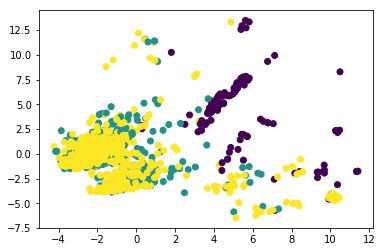

In [37]:
# Scale features so that they have a mean of zero and variance of 1
# scaled all the matr
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ar_tot = ss.fit_transform(X)
X_scaled = ss.fit_transform(X_train)
X_valid_scaled = ss.fit_transform(X_valid)

# Apply PCA
from sklearn.decomposition import PCA
model_tot = PCA()
transformed = model_tot.fit_transform(ar_tot)
print(transformed.shape)
plt.scatter(transformed[:,0], transformed[:,1], c = y);

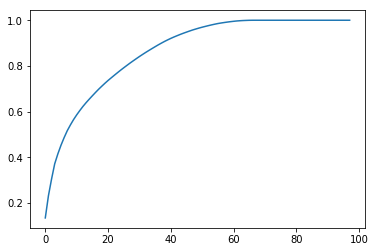

In [38]:
# finding the correct number of componets that explain the variance in the dataset

plt.plot(np.cumsum(model_tot.explained_variance_ratio_));

Text(0.5,1,'Finding the ideal number of n_components parameter for PCA')

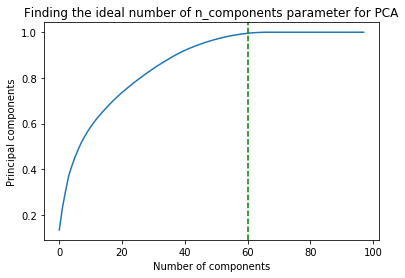

In [39]:
# Plot explained total variance of principal components against number of components
# make a vertical line to ensure you are extracting the right point on the graph

plt.plot(np.cumsum(model_tot.explained_variance_ratio_))
plt.axvline(x=60, color='green', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Principal components')
plt.title('Finding the ideal number of n_components parameter for PCA')

In [40]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2',
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe2 = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64, 78],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe2, param_grid, iid=False, cv=10,
                      return_train_score=False)

search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.410):
{'logistic__alpha': 0.0001, 'pca__n_components': 5}


In [41]:
# Build a pipeline of PCA w/ 60 components and a logistic regression
pca = PCA(n_components=88, random_state=42)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
pipe.fit(X_scaled, y_train)

print("Accuracy on the test set: {:.3f}".format(pipe.score(X_valid_scaled, y_valid)))

Accuracy on the test set: 0.622


### Accuracy 62%

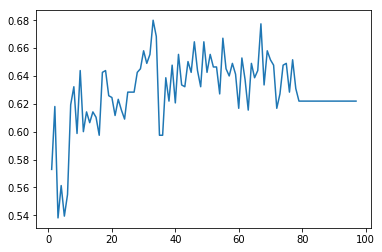

In [42]:
# make an array with values between 1 and 98 
x1 = np.arange(1,98)

# make another empty list
y1 = []

# make a loop that goes through each value between 1 to 98
for i in x1:
    # Instantiate a Principal Component analysis that will take one value in the array multiple times
    # till you reach the end of the array which is 98
    pca = PCA(n_components=i, random_state=42)
    
    # Make a pipeline object with pca and logistic regression called
    pipe = Pipeline(steps=[("pca", pca), ('logistic', logistic)])
    
    # fit with both pca and log regression
    pipe.fit(X_scaled, y_train)
    
    # score the values obtained to y1
    y1.append(pipe.score(X_valid_scaled, y_valid))
plt.plot(x1, y1)

In [43]:
y_pred = pipe.predict(y_valid.reshape(-1, 1))

In [44]:
y_valid.shape

(775,)

In [45]:
y_pred.shape

(775,)

## precision      recall         f1-score       support

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        90
          0       0.00      0.00      0.00       277
          1       0.60      1.00      0.75       408

avg / total       0.31      0.53      0.39       775



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# With an imputer

steps = [('Imputer', Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)),
         ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
         ('SVM', SVC(kernel = 'rbf', cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]

pipeline = Pipeline(steps)

# Specifying the hyperparameter space
parameters = {'SVM__C':[1] ,
              'SVM__gamma':[0.01]}


# Instantiate the GridSearchCV
grid2 = GridSearchCV(pipeline, param_grid = parameters)

# Fit to the training set
grid2.fit(X_scaled, y_train)

# Predict the labels of the test set
y_pred = grid2.predict(y_valid.reshape(-1, 1))

# Compute and print metrics
print("Accuracy: {}".format(grid2.score(X_valid_scaled, y_valid)))
print(classification_report(y_valid, y_pred))
print("Tuned Model Parameters: {}".format(grid2.best_params_))

score = cross_val_score(SVC(kernel = 'rbf', C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), X, y, cv = 5, scoring = 'roc_auc').mean()

print("Accuracy mean cross-validation score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

ValueError: X has 1 features per sample, expected 98